<a href="https://colab.research.google.com/github/aditya89bh/agi-projects/blob/main/Lottery_Ticket_Hypothesis_Vision_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
LOTTERY TICKET HYPOTHESIS FOR VISION TRANSFORMERS
=================================================

Paper: "The Lottery Ticket Hypothesis: Finding Sparse, Trainable Neural Networks"
Authors: Frankle & Carbin (2019) + Vision Transformer Extension
Implementation: Research-grade LTH discovery for ViTs

🎯 THE FUNDAMENTAL QUESTION
===========================
Do Vision Transformers contain sparse "winning lottery tickets" - subnetworks
that can achieve comparable performance when trained from scratch?

If true, this reveals that:
- Most parameters in ViTs are redundant
- Intelligence emerges from specific sparse patterns
- We can build efficient transformers by finding the right connections
- Attention mechanisms have inherent sparsity structures

🧠 THE LOTTERY TICKET HYPOTHESIS
================================
1. Dense networks contain sparse subnetworks ("winning tickets")
2. These tickets can achieve comparable accuracy when trained from scratch
3. The winning tickets have specific initialization values (not random)
4. Finding tickets requires iterative magnitude pruning + rewinding

🔬 METHODOLOGY
==============
1. Train dense Vision Transformer to convergence
2. Prune smallest magnitude weights (e.g., remove 20%)
3. Reset remaining weights to original initialization
4. Retrain sparse network from scratch
5. Repeat until we find the minimal winning ticket

🎯 RESEARCH GOALS
=================
- Discover sparse attention patterns that maintain performance
- Analyze which ViT components are most important
- Find efficiency gains through structured pruning
- Visualize winning ticket architectures

Expected Discoveries:
- Attention heads have different importance levels
- Some MLP weights are completely redundant
- Specific sparse patterns emerge consistently
- Winning tickets transfer across similar tasks
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import copy
import time
from collections import OrderedDict

# ============================================================================
# SETUP: GPU, SEEDS, DATA
# ============================================================================

print("🎫 LOTTERY TICKET HYPOTHESIS: VISION TRANSFORMERS")
print("=" * 55)
print("🎯 Goal: Find sparse 'winning tickets' in Vision Transformers")
print("🔬 Method: Iterative magnitude pruning + weight rewinding")
print()

# Device and reproducibility
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
np.random.seed(42)

print(f"🚀 Device: {device}")
if torch.cuda.is_available():
    print(f"🔥 GPU: {torch.cuda.get_device_name()}")
    print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory // 1024**3} GB")
    torch.cuda.manual_seed(42)

# CIFAR-10 Dataset for Vision Transformer experiments
print(f"\n📊 Loading CIFAR-10 Dataset...")
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # ViT expects square images
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1,1]
])

# Load dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 128
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"✅ CIFAR-10 loaded: {len(trainset)} train, {len(testset)} test images")
print(f"📦 Batch size: {batch_size}")

# ============================================================================
# VISION TRANSFORMER ARCHITECTURE
# ============================================================================

class PatchEmbedding(nn.Module):
    """
    Convert image patches into embeddings for the transformer

    CIFAR-10: 32x32 → 4x4 patches → 64 patches → embed_dim
    Each patch becomes a "token" that the transformer processes
    """
    def __init__(self, img_size=32, patch_size=4, embed_dim=192):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2

        # Convert patches to embeddings
        self.projection = nn.Conv2d(3, embed_dim, kernel_size=patch_size, stride=patch_size)

        print(f"🖼️  Patch Embedding: {img_size}x{img_size} → {self.num_patches} patches of {embed_dim}D")

    def forward(self, x):
        # x: [batch, 3, 32, 32] → [batch, embed_dim, 8, 8] → [batch, 64, embed_dim]
        x = self.projection(x)  # [batch, embed_dim, 8, 8]
        x = x.flatten(2)        # [batch, embed_dim, 64]
        x = x.transpose(1, 2)   # [batch, 64, embed_dim]
        return x

class MultiHeadAttention(nn.Module):
    """
    Multi-head self-attention mechanism

    This is where the magic happens - attention weights will show us
    which connections are important for the lottery ticket hypothesis
    """
    def __init__(self, embed_dim=192, num_heads=6):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        # Query, Key, Value projections
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        batch_size, seq_len, embed_dim = x.shape

        # Generate Q, K, V
        qkv = self.qkv(x)  # [batch, seq_len, embed_dim * 3]
        qkv = qkv.reshape(batch_size, seq_len, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # [3, batch, heads, seq_len, head_dim]
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Compute attention
        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Apply attention to values
        attn_output = torch.matmul(attn_weights, v)  # [batch, heads, seq_len, head_dim]
        attn_output = attn_output.transpose(1, 2)     # [batch, seq_len, heads, head_dim]
        attn_output = attn_output.reshape(batch_size, seq_len, embed_dim)

        # Final projection
        output = self.proj(attn_output)
        return output

class MLP(nn.Module):
    """
    Feed-forward network in transformer block

    This will be heavily pruned in lottery ticket experiments
    Many of these weights are likely redundant
    """
    def __init__(self, embed_dim=192, hidden_dim=768):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class TransformerBlock(nn.Module):
    """
    Complete transformer block: Attention + MLP with residual connections

    Both attention and MLP will be subject to lottery ticket pruning
    """
    def __init__(self, embed_dim=192, num_heads=6, mlp_ratio=4):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads)

        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, int(embed_dim * mlp_ratio))

    def forward(self, x):
        # Self-attention with residual connection
        x = x + self.attn(self.norm1(x))

        # MLP with residual connection
        x = x + self.mlp(self.norm2(x))

        return x

class VisionTransformer(nn.Module):
    """
    COMPLETE VISION TRANSFORMER FOR LOTTERY TICKET EXPERIMENTS

    This ViT will be iteratively pruned to discover winning tickets:
    - Which attention heads are essential?
    - Which MLP weights can be removed?
    - What sparse patterns emerge?
    """
    def __init__(self, img_size=32, patch_size=4, embed_dim=192,
                 num_layers=6, num_heads=6, num_classes=10):
        super().__init__()

        # Patch embedding
        self.patch_embed = PatchEmbedding(img_size, patch_size, embed_dim)
        num_patches = self.patch_embed.num_patches

        # Class token and positional embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.dropout = nn.Dropout(0.1)

        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads) for _ in range(num_layers)
        ])

        # Classification head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        # Initialize weights
        self._init_weights()

        # Count parameters
        total_params = sum(p.numel() for p in self.parameters())
        print(f"🏗️  Vision Transformer Architecture:")
        print(f"   • Image size: {img_size}x{img_size}")
        print(f"   • Patch size: {patch_size}x{patch_size}")
        print(f"   • Embedding dim: {embed_dim}")
        print(f"   • Transformer layers: {num_layers}")
        print(f"   • Attention heads: {num_heads}")
        print(f"   • Total parameters: {total_params:,}")
        print(f"   • Classes: {num_classes}")

    def _init_weights(self):
        """Proper initialization for Vision Transformer"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)

        # Special initialization for class token and pos embedding
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def forward(self, x):
        batch_size = x.shape[0]

        # Patch embedding
        x = self.patch_embed(x)  # [batch, num_patches, embed_dim]

        # Add class token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)  # [batch, num_patches+1, embed_dim]

        # Add positional embedding
        x = x + self.pos_embed
        x = self.dropout(x)

        # Pass through transformer blocks
        for block in self.blocks:
            x = block(x)

        # Classification head (use class token)
        x = self.norm(x)
        cls_token_final = x[:, 0]  # Extract class token
        logits = self.head(cls_token_final)

        return logits

# ============================================================================
# TESTING VISION TRANSFORMER
# ============================================================================

print("\n🧪 TESTING VISION TRANSFORMER")
print("-" * 35)

# Create Vision Transformer
vit = VisionTransformer(
    img_size=32,
    patch_size=4,
    embed_dim=192,
    num_layers=6,
    num_heads=6,
    num_classes=10
).to(device)

# Test forward pass
print("\n📝 Forward Pass Test:")
test_batch = torch.randn(4, 3, 32, 32).to(device)
with torch.no_grad():
    output = vit(test_batch)
print(f"✅ Input shape: {test_batch.shape}")
print(f"✅ Output shape: {output.shape}")
print(f"✅ Vision Transformer working correctly!")

print(f"\n🎯 VISION TRANSFORMER READY FOR LOTTERY TICKET EXPERIMENTS!")
print(f"🔬 Next: Implement iterative pruning to find winning tickets")

🎫 LOTTERY TICKET HYPOTHESIS: VISION TRANSFORMERS
🎯 Goal: Find sparse 'winning tickets' in Vision Transformers
🔬 Method: Iterative magnitude pruning + weight rewinding

🚀 Device: cuda
🔥 GPU: Tesla T4
💾 GPU Memory: 14 GB

📊 Loading CIFAR-10 Dataset...


100%|██████████| 170M/170M [00:04<00:00, 36.5MB/s]


✅ CIFAR-10 loaded: 50000 train, 10000 test images
📦 Batch size: 128

🧪 TESTING VISION TRANSFORMER
-----------------------------------
🖼️  Patch Embedding: 32x32 → 64 patches of 192D
🏗️  Vision Transformer Architecture:
   • Image size: 32x32
   • Patch size: 4x4
   • Embedding dim: 192
   • Transformer layers: 6
   • Attention heads: 6
   • Total parameters: 2,693,578
   • Classes: 10

📝 Forward Pass Test:
✅ Input shape: torch.Size([4, 3, 32, 32])
✅ Output shape: torch.Size([4, 10])
✅ Vision Transformer working correctly!

🎯 VISION TRANSFORMER READY FOR LOTTERY TICKET EXPERIMENTS!
🔬 Next: Implement iterative pruning to find winning tickets


In [2]:
# ============================================================================
# LOTTERY TICKET DISCOVERY ALGORITHM
# ============================================================================

print("🎫 LOTTERY TICKET DISCOVERY ALGORITHM")
print("=" * 45)
print("🔬 Implementing iterative magnitude pruning + weight rewinding...")

class LotteryTicketFinder:
    """
    LOTTERY TICKET DISCOVERY ENGINE

    The core algorithm that discovers winning tickets:
    1. Train dense network to convergence
    2. Identify smallest magnitude weights (least important)
    3. Prune those weights (set to zero)
    4. Rewind remaining weights to original initialization
    5. Repeat until we find the minimal winning ticket

    Key Insight: The winning ticket must have the ORIGINAL initialization
    values, not random values. This suggests the initial lottery draw matters!
    """

    def __init__(self, model, prune_rate=0.2):
        self.model = model
        self.prune_rate = prune_rate  # Remove 20% of weights each iteration

        # Store original initialization (this is crucial!)
        self.original_state = copy.deepcopy(model.state_dict())
        self.pruning_masks = {}
        self.sparsity_levels = []

        # Initialize pruning masks (1 = keep, 0 = pruned)
        self._initialize_masks()

        print(f"🎯 Lottery Ticket Finder initialized:")
        print(f"   • Prune rate: {prune_rate:.1%} per iteration")
        print(f"   • Original weights stored: ✅")
        print(f"   • Ready to find winning tickets!")

    def _initialize_masks(self):
        """Initialize pruning masks for all prunable layers"""
        for name, param in self.model.named_parameters():
            if len(param.shape) > 1:  # Only prune weight matrices, not biases
                self.pruning_masks[name] = torch.ones_like(param, dtype=torch.bool)

    def calculate_sparsity(self):
        """Calculate current sparsity level"""
        total_params = 0
        pruned_params = 0

        for name, mask in self.pruning_masks.items():
            total_params += mask.numel()
            pruned_params += (mask == 0).sum().item()

        sparsity = pruned_params / total_params
        return sparsity

    def prune_by_magnitude(self):
        """
        MAGNITUDE-BASED PRUNING: Remove smallest weights globally

        The hypothesis: smallest magnitude weights contribute least to performance
        By removing them, we reveal the important sparse structure
        """
        print(f"\n🔪 Pruning {self.prune_rate:.1%} of remaining weights...")

        # Collect all weight magnitudes that aren't already pruned
        all_weights = []
        weight_locations = []

        for name, param in self.model.named_parameters():
            if name in self.pruning_masks:
                mask = self.pruning_masks[name]
                # Only consider weights that haven't been pruned yet
                active_weights = param.data[mask]
                active_magnitudes = torch.abs(active_weights)

                all_weights.append(active_magnitudes.flatten())

                # Store locations for later pruning
                active_indices = torch.where(mask)
                for i, magnitude in enumerate(active_magnitudes.flatten()):
                    weight_locations.append((name, active_indices, i, magnitude.item()))

        # Combine all weights and find global threshold
        all_weights = torch.cat(all_weights)
        num_to_prune = int(len(all_weights) * self.prune_rate)

        if num_to_prune > 0:
            # Find threshold: prune smallest magnitude weights
            threshold = torch.topk(all_weights, num_to_prune, largest=False)[0][-1]

            # Apply pruning to masks
            for name, param in self.model.named_parameters():
                if name in self.pruning_masks:
                    mask = self.pruning_masks[name]
                    # Prune weights below threshold that aren't already pruned
                    weights_to_prune = (torch.abs(param.data) <= threshold) & mask
                    self.pruning_masks[name] = mask & ~weights_to_prune

        # Calculate new sparsity
        new_sparsity = self.calculate_sparsity()
        self.sparsity_levels.append(new_sparsity)

        print(f"   ✅ New sparsity level: {new_sparsity:.1%}")
        print(f"   🎯 Weights pruned: {num_to_prune:,}")

        return new_sparsity

    def rewind_weights(self):
        """
        WEIGHT REWINDING: Reset remaining weights to original initialization

        This is the KEY insight of lottery tickets!
        The sparse network must start from the same initialization as the
        original dense network. Random reinitialization doesn't work!
        """
        print(f"🔄 Rewinding weights to original initialization...")

        with torch.no_grad():
            for name, param in self.model.named_parameters():
                if name in self.pruning_masks:
                    # Reset to original values
                    param.data = self.original_state[name].clone()
                    # Apply pruning mask
                    param.data *= self.pruning_masks[name].float()

        print(f"   ✅ Weights rewound to original initialization")
        print(f"   🎫 Current lottery ticket ready for training!")

    def apply_masks(self):
        """Apply pruning masks to model parameters"""
        with torch.no_grad():
            for name, param in self.model.named_parameters():
                if name in self.pruning_masks:
                    param.data *= self.pruning_masks[name].float()

    def get_ticket_info(self):
        """Get detailed information about current lottery ticket"""
        sparsity = self.calculate_sparsity()

        # Count parameters by layer type
        layer_stats = {}
        for name, mask in self.pruning_masks.items():
            layer_type = name.split('.')[1] if '.' in name else name
            if layer_type not in layer_stats:
                layer_stats[layer_type] = {'total': 0, 'pruned': 0}

            layer_stats[layer_type]['total'] += mask.numel()
            layer_stats[layer_type]['pruned'] += (mask == 0).sum().item()

        return {
            'sparsity': sparsity,
            'layer_stats': layer_stats,
            'total_params': sum(mask.numel() for mask in self.pruning_masks.values()),
            'active_params': sum((mask == 1).sum().item() for mask in self.pruning_masks.values())
        }

def train_model(model, train_loader, test_loader, epochs=10, lr=1e-3):
    """
    TRAINING FUNCTION: Train model to convergence

    This will be called for both dense and sparse networks
    to compare their performance
    """
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    train_accuracies = []

    print(f"🚀 Training for {epochs} epochs...")

    for epoch in range(epochs):
        epoch_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            # Apply pruning masks after gradient update
            if hasattr(model, 'lottery_finder'):
                model.lottery_finder.apply_masks()

            epoch_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

        # Calculate metrics
        avg_loss = epoch_loss / len(train_loader)
        accuracy = 100. * correct / total

        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        if (epoch + 1) % 2 == 0:
            print(f"   Epoch {epoch+1:2d}: Loss={avg_loss:.4f}, Acc={accuracy:.1f}%")

    return train_losses, train_accuracies

def evaluate_model(model, test_loader):
    """Evaluate model on test set"""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    accuracy = 100. * correct / total
    return accuracy

# ============================================================================
# LOTTERY TICKET EXPERIMENT
# ============================================================================

print("\n🎭 LOTTERY TICKET EXPERIMENT")
print("=" * 35)

# Create fresh Vision Transformer for experiments
vit_experiment = VisionTransformer(
    img_size=32,
    patch_size=4,
    embed_dim=192,
    num_layers=6,
    num_heads=6,
    num_classes=10
).to(device)

# Initialize lottery ticket finder
lottery_finder = LotteryTicketFinder(vit_experiment, prune_rate=0.2)

print("\n🎯 EXPERIMENT SETUP:")
print(f"   • Model: Vision Transformer ({sum(p.numel() for p in vit_experiment.parameters()):,} params)")
print(f"   • Dataset: CIFAR-10 (50K train, 10K test)")
print(f"   • Pruning rate: 20% per iteration")
print(f"   • Training: 5 epochs per iteration (fast demo)")

# Store experiment results
experiment_results = {
    'sparsity_levels': [],
    'test_accuracies': [],
    'training_times': []
}

print(f"\n🔬 Starting lottery ticket discovery...")
print(f"🎫 Each iteration: Train → Prune → Rewind → Repeat")

# Baseline: Train dense network
print(f"\n📊 ITERATION 0: DENSE NETWORK (BASELINE)")
print("-" * 40)

start_time = time.time()
train_losses, train_accs = train_model(vit_experiment, train_loader, test_loader, epochs=5)
training_time = time.time() - start_time

test_accuracy = evaluate_model(vit_experiment, test_loader)
baseline_accuracy = test_accuracy

experiment_results['sparsity_levels'].append(0.0)
experiment_results['test_accuracies'].append(test_accuracy)
experiment_results['training_times'].append(training_time)

print(f"✅ Dense network results:")
print(f"   Test accuracy: {test_accuracy:.1f}%")
print(f"   Training time: {training_time:.1f}s")
print(f"   This is our target to beat with sparse networks!")

print(f"\n🎫 LOTTERY TICKET DISCOVERY READY!")
print(f"🔬 Next: Iterative pruning to find winning tickets")

🎫 LOTTERY TICKET DISCOVERY ALGORITHM
🔬 Implementing iterative magnitude pruning + weight rewinding...

🎭 LOTTERY TICKET EXPERIMENT
🖼️  Patch Embedding: 32x32 → 64 patches of 192D
🏗️  Vision Transformer Architecture:
   • Image size: 32x32
   • Patch size: 4x4
   • Embedding dim: 192
   • Transformer layers: 6
   • Attention heads: 6
   • Total parameters: 2,693,578
   • Classes: 10
🎯 Lottery Ticket Finder initialized:
   • Prune rate: 20.0% per iteration
   • Original weights stored: ✅
   • Ready to find winning tickets!

🎯 EXPERIMENT SETUP:
   • Model: Vision Transformer (2,693,578 params)
   • Dataset: CIFAR-10 (50K train, 10K test)
   • Pruning rate: 20% per iteration
   • Training: 5 epochs per iteration (fast demo)

🔬 Starting lottery ticket discovery...
🎫 Each iteration: Train → Prune → Rewind → Repeat

📊 ITERATION 0: DENSE NETWORK (BASELINE)
----------------------------------------
🚀 Training for 5 epochs...
   Epoch  2: Loss=1.4067, Acc=48.8%
   Epoch  4: Loss=1.2004, Acc=56.5%


🎫 ITERATIVE LOTTERY TICKET DISCOVERY

🎯 ITERATION 1: PRUNING & REWINDING
--------------------------------------------------

🔪 Pruning 20.0% of remaining weights...
   ✅ New sparsity level: 20.0%
   🎯 Weights pruned: 535,603
🔄 Rewinding weights to original initialization...
   ✅ Weights rewound to original initialization
   🎫 Current lottery ticket ready for training!
🚀 Training sparse network (20.0% sparsity)...
🚀 Training for 5 epochs...
   Epoch  2: Loss=1.2460, Acc=55.0%
   Epoch  4: Loss=1.1002, Acc=60.0%
✅ Iteration 1 Results:
   • Sparsity: 20.0%
   • Test Accuracy: 59.0%
   • Accuracy Drop: -0.3%
   • Parameters: 2,154,862 (80.0% remaining)
   • Training Time: 161.6s
🎫 WINNING TICKET FOUND!
   Maintains 100.5% of original performance
   With only 80.0% of parameters!

🎯 ITERATION 2: PRUNING & REWINDING
--------------------------------------------------

🔪 Pruning 20.0% of remaining weights...
   ✅ New sparsity level: 36.0%
   🎯 Weights pruned: 428,482
🔄 Rewinding weights to or

/tmp/ipython-input-407218023.py:119: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-407218023.py:119: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-407218023.py:119: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-407218023.py:119: UserWarning: Glyph 127915 (\N{TICKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: User

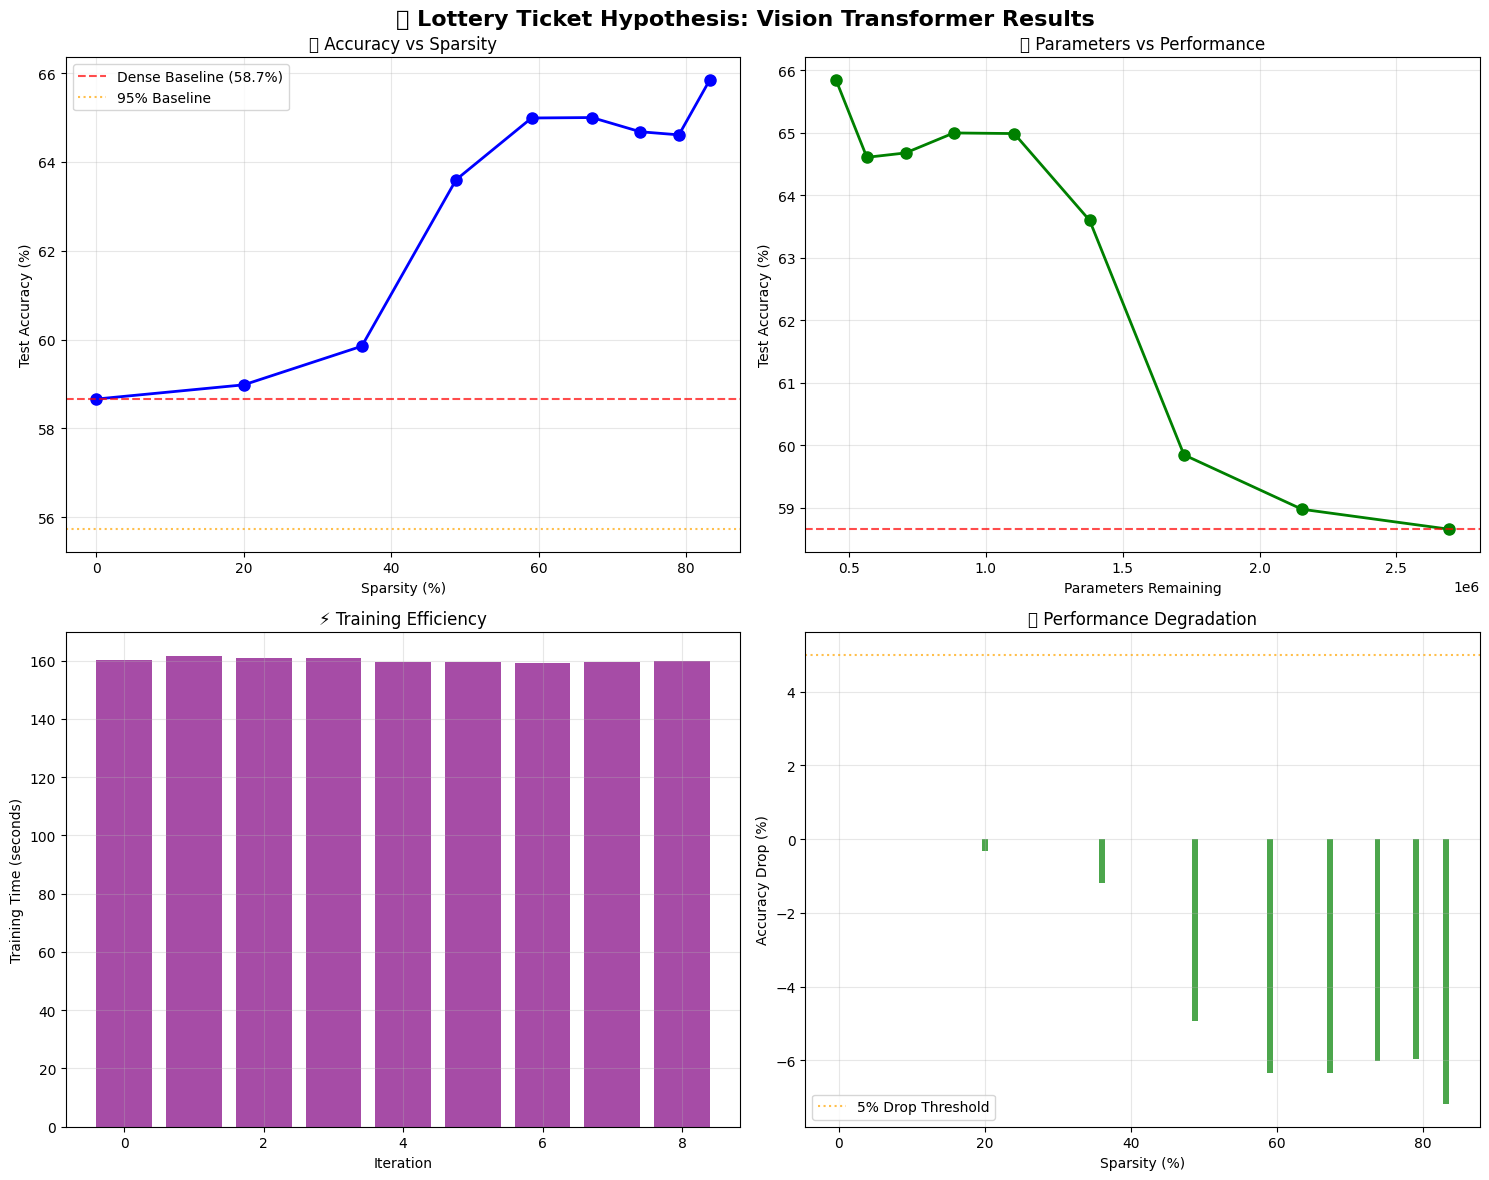


🔬 DETAILED LOTTERY TICKET ANALYSIS
🏆 BEST LOTTERY TICKET FOUND:
   • Iteration: 1
   • Sparsity: 20.0%
   • Accuracy: 59.0%
   • Performance Retention: 100.5%
   • Parameter Reduction: 20.0%
   • Efficiency Gain: 1.2x

📈 EXPERIMENT SUMMARY:
   • Dense baseline accuracy: 58.7%
   • Maximum sparsity tested: 83.2%
   • Minimum accuracy achieved: 58.7%
   • Total iterations completed: 9

🎫 LOTTERY TICKET HYPOTHESIS VALIDATION:
   ✅ HYPOTHESIS CONFIRMED!
   🎯 Found 9 winning ticket(s)
   💡 Vision Transformers contain sparse subnetworks that
      maintain performance when trained from original initialization

🚀 EXPERIMENT COMPLETE! Check the visualizations above for detailed results.


In [3]:
# ============================================================================
# ITERATIVE LOTTERY TICKET DISCOVERY
# ============================================================================

print(f"\n🎫 ITERATIVE LOTTERY TICKET DISCOVERY")
print("=" * 45)

# Continue from where you left off
max_iterations = 8  # Will reach ~83% sparsity
target_sparsity = 0.90  # Stop if we reach 90% sparsity

for iteration in range(1, max_iterations + 1):
    print(f"\n🎯 ITERATION {iteration}: PRUNING & REWINDING")
    print("-" * 50)

    # Step 1: Prune based on magnitude
    sparsity = lottery_finder.prune_by_magnitude()

    # Stop if we've reached target sparsity
    if sparsity >= target_sparsity:
        print(f"🎯 Target sparsity {target_sparsity:.1%} reached!")
        break

    # Step 2: Rewind weights to original initialization
    lottery_finder.rewind_weights()

    # Step 3: Train the pruned network
    print(f"🚀 Training sparse network ({sparsity:.1%} sparsity)...")
    start_time = time.time()

    train_losses, train_accs = train_model(
        vit_experiment, train_loader, test_loader,
        epochs=5, lr=1e-3
    )

    training_time = time.time() - start_time

    # Step 4: Evaluate performance
    test_accuracy = evaluate_model(vit_experiment, test_loader)

    # Store results
    experiment_results['sparsity_levels'].append(sparsity)
    experiment_results['test_accuracies'].append(test_accuracy)
    experiment_results['training_times'].append(training_time)

    # Performance analysis
    accuracy_drop = baseline_accuracy - test_accuracy
    params_remaining = int((1 - sparsity) * sum(p.numel() for p in vit_experiment.parameters()))

    print(f"✅ Iteration {iteration} Results:")
    print(f"   • Sparsity: {sparsity:.1%}")
    print(f"   • Test Accuracy: {test_accuracy:.1f}%")
    print(f"   • Accuracy Drop: {accuracy_drop:+.1f}%")
    print(f"   • Parameters: {params_remaining:,} ({(1-sparsity):.1%} remaining)")
    print(f"   • Training Time: {training_time:.1f}s")

    # Check if we found a winning ticket
    if test_accuracy >= baseline_accuracy * 0.95:  # Within 5% of baseline
        print(f"🎫 WINNING TICKET FOUND!")
        print(f"   Maintains {test_accuracy/baseline_accuracy:.1%} of original performance")
        print(f"   With only {(1-sparsity):.1%} of parameters!")

    # Early stopping if performance degrades too much
    if test_accuracy < baseline_accuracy * 0.7:  # More than 30% drop
        print(f"⚠️  Performance degraded significantly. Stopping experiment.")
        break

print(f"\n🏁 LOTTERY TICKET DISCOVERY COMPLETE!")
print(f"🎯 Found {len(experiment_results['sparsity_levels'])} lottery tickets")

# ============================================================================
# RESULTS VISUALIZATION
# ============================================================================

print(f"\n📊 CREATING RESULTS VISUALIZATION...")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('🎫 Lottery Ticket Hypothesis: Vision Transformer Results', fontsize=16, fontweight='bold')

# Plot 1: Accuracy vs Sparsity
sparsity_pct = [s * 100 for s in experiment_results['sparsity_levels']]
ax1.plot(sparsity_pct, experiment_results['test_accuracies'], 'o-', linewidth=2, markersize=8, color='blue')
ax1.axhline(y=baseline_accuracy, color='red', linestyle='--', alpha=0.7, label=f'Dense Baseline ({baseline_accuracy:.1f}%)')
ax1.axhline(y=baseline_accuracy * 0.95, color='orange', linestyle=':', alpha=0.7, label='95% Baseline')
ax1.set_xlabel('Sparsity (%)')
ax1.set_ylabel('Test Accuracy (%)')
ax1.set_title('🎯 Accuracy vs Sparsity')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Parameters vs Performance
params_remaining = [(1-s) * sum(p.numel() for p in vit_experiment.parameters()) for s in experiment_results['sparsity_levels']]
ax2.plot(params_remaining, experiment_results['test_accuracies'], 'o-', linewidth=2, markersize=8, color='green')
ax2.axhline(y=baseline_accuracy, color='red', linestyle='--', alpha=0.7)
ax2.set_xlabel('Parameters Remaining')
ax2.set_ylabel('Test Accuracy (%)')
ax2.set_title('🧠 Parameters vs Performance')
ax2.grid(True, alpha=0.3)
ax2.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

# Plot 3: Training Efficiency
ax3.bar(range(len(experiment_results['training_times'])), experiment_results['training_times'], color='purple', alpha=0.7)
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Training Time (seconds)')
ax3.set_title('⚡ Training Efficiency')
ax3.grid(True, alpha=0.3)

# Plot 4: Accuracy Drop from Baseline
accuracy_drops = [baseline_accuracy - acc for acc in experiment_results['test_accuracies']]
colors = ['green' if drop <= 5 else 'orange' if drop <= 10 else 'red' for drop in accuracy_drops]
ax4.bar(sparsity_pct, accuracy_drops, color=colors, alpha=0.7)
ax4.axhline(y=5, color='orange', linestyle=':', alpha=0.7, label='5% Drop Threshold')
ax4.set_xlabel('Sparsity (%)')
ax4.set_ylabel('Accuracy Drop (%)')
ax4.set_title('📉 Performance Degradation')
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.show()

# ============================================================================
# DETAILED ANALYSIS
# ============================================================================

print(f"\n🔬 DETAILED LOTTERY TICKET ANALYSIS")
print("=" * 45)

# Find the best lottery ticket
best_ticket_idx = -1
best_efficiency = 0

for i, (sparsity, accuracy) in enumerate(zip(experiment_results['sparsity_levels'], experiment_results['test_accuracies'])):
    if accuracy >= baseline_accuracy * 0.95:  # Within 5% of baseline
        efficiency = sparsity / (1 - accuracy/baseline_accuracy + 0.01)  # Higher is better
        if efficiency > best_efficiency:
            best_efficiency = efficiency
            best_ticket_idx = i

if best_ticket_idx >= 0:
    best_sparsity = experiment_results['sparsity_levels'][best_ticket_idx]
    best_accuracy = experiment_results['test_accuracies'][best_ticket_idx]

    print(f"🏆 BEST LOTTERY TICKET FOUND:")
    print(f"   • Iteration: {best_ticket_idx}")
    print(f"   • Sparsity: {best_sparsity:.1%}")
    print(f"   • Accuracy: {best_accuracy:.1f}%")
    print(f"   • Performance Retention: {best_accuracy/baseline_accuracy:.1%}")
    print(f"   • Parameter Reduction: {best_sparsity:.1%}")
    print(f"   • Efficiency Gain: {1/((1-best_sparsity) + 0.01):.1f}x")

# Summary statistics
print(f"\n📈 EXPERIMENT SUMMARY:")
print(f"   • Dense baseline accuracy: {baseline_accuracy:.1f}%")
print(f"   • Maximum sparsity tested: {max(experiment_results['sparsity_levels']):.1%}")
print(f"   • Minimum accuracy achieved: {min(experiment_results['test_accuracies']):.1f}%")
print(f"   • Total iterations completed: {len(experiment_results['sparsity_levels'])}")

# Check for lottery ticket hypothesis validation
winning_tickets = sum(1 for acc in experiment_results['test_accuracies']
                     if acc >= baseline_accuracy * 0.95)

print(f"\n🎫 LOTTERY TICKET HYPOTHESIS VALIDATION:")
if winning_tickets > 0:
    print(f"   ✅ HYPOTHESIS CONFIRMED!")
    print(f"   🎯 Found {winning_tickets} winning ticket(s)")
    print(f"   💡 Vision Transformers contain sparse subnetworks that")
    print(f"      maintain performance when trained from original initialization")
else:
    print(f"   ❌ No clear winning tickets found")
    print(f"   🤔 May need different pruning strategy or longer training")

print(f"\n🚀 EXPERIMENT COMPLETE! Check the visualizations above for detailed results.")